## Polymer Project: 
## Implementation of the pivot algorithm to simulate Self-avoiding-random walks

 Names: Mandus Aldag, Alexandros Mylanos

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
def check_self_avoidance(coords, pivot = None):
    # False = Self avoidant
    # True = not Self avoidant

    if pivot == None:
        N = np.size(coords, axis=1)
        hashset = set()
        for i in range(N):
            tmp_tuple = tuple(coords[:,i])
            if tmp_tuple in hashset:
                return True
            else:
                hashset.add(tmp_tuple)
                
        
        return False
    
    else:
        N = np.size(coords, axis=1)
        if pivot >= N//2:
            longer_site= pivot 
            shorter_site= N-pivot-1
            dir = -1
        else:
            longer_site = N-pivot-1
            shorter_site = pivot
            dir = 1
       
        hashset=set()
        for i in range(1,longer_site+1):
            if i > shorter_site:   # Case when we scan only in the longer direction from thepivot because the short direction was already fully scanned
                tmp_tuple = tuple(coords[:,pivot+i*dir])
                if tmp_tuple in hashset:
                    return True
                else:
                    hashset.add(tmp_tuple)
            else: # Check in both directions of the pivot
                tmp_tuple = tuple(coords[:,pivot+i])
                if tmp_tuple in hashset:
                    return True
                else: 
                    hashset.add(tmp_tuple)
                tmp_tuple = tuple(coords[:,pivot-i])
                if tmp_tuple in hashset:
                    return True
                else: 
                    hashset.add(tmp_tuple)
        return False
                    

In [4]:
def generate_random_walk(L):
    coord = np.zeros((2,L),dtype=int)
    for l in range(1,L):
        direction = np.random.randint(0,4) # clock wise starting from the top
        if direction == 0:
            coord[0,l] = coord[0,l-1]
            coord[1,l] = coord[1,l-1]+1 

        elif  direction == 1:
            coord[0,l] = coord[0,l-1]+1
            coord[1,l] = coord[1,l-1]
        
        elif  direction == 2:
            coord[0,l] = coord[0,l-1]
            coord[1,l] = coord[1,l-1]-1

        elif  direction == 3:
            coord[0,l] = coord[0,l-1]-1
            coord[1,l] =  coord[1,l-1]
    
    return coord
        

In [5]:
def initial_SAW(N: int): #Dimerisation
    if N <= 5:
        tmp = True
        while tmp:
            walk = generate_random_walk(N)
            tmp = check_self_avoidance(walk)
        return walk



    else:
        tmp = True
        while tmp:
            first = initial_SAW(N//2)
            second = initial_SAW(N-N//2+1)
            translated = (first[:,-1]+second.T).T
            concatenated = np.concatenate((first,translated[:,1:]),axis=1)
            tmp = check_self_avoidance(concatenated)

        return concatenated


In [14]:
def pivot_point(coord):
    N = np.size(coord,axis=1)
    return np.random.randint(1,N)

def symmetry_op(coord):
    N = np.size(coord,axis=1)
    g = np.random.randint(0,7)
    if g==0: #+90°(mathematically)
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,-1],[1,0]]), coord[:,i])
    elif g==1: #-90°(mathematically)
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,1],[-1,0]]), coord[:,i])
    elif g==2: #180°
        for i in range(N):
            coord[:,i] = np.dot(np.array([[-1,0],[0,-1]]), coord[:,i])
    elif g==3: #x-axis symmetry
        for i in range(N):
            coord[:,i] = np.dot(np.array([[1,0],[0,-1]]), coord[:,i])
    elif g==4: #y-axis symmetry
        for i in range(N):
            coord[:,i] = np.dot(np.array([[-1,0],[0,1]]), coord[:,i])
    elif g==5: #diagonal reflection upperright-bottomleft
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,1],[1,0]]), coord[:,i])
    elif g==6: #diagonal reflection upperleft-bottomright
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,-1],[-1,0]]), coord[:,i])
    #print("g = ",g)
    return coord
    

In [21]:
def pivot_step(coord):
    N = np.size(coord,axis=1)
    
    pivot = np.random.randint(1,N-1)
    #print("pivot = ",pivot)
    to_be_operated = coord[:,pivot:]
    to_be_operated = (to_be_operated.T-to_be_operated[:,0]).T
    operated = symmetry_op(to_be_operated)
    operated = (operated.T+coord[:,pivot]).T

    coord_new = np.concatenate((coord[:,:pivot],operated),axis=1)
    not_selfavoidant = check_self_avoidance(coord_new,pivot)
    if not_selfavoidant:
        return coord
    else:
        return coord_new


In [26]:
def squared_end_to_end(coord):
    return np.linalg.norm(coord[:,-1])**2

def squared_gyration(coord):
    N = np.size(coord,axis=1)
    a = (1/N * np.sum(coord,axis=1))
    inbracket = np.dot(a,a)
    result = 0
    for i in range(N):
        result += np.dot(coord[:,i], coord[:,i])-inbracket
    return 1/N * result

In [23]:
def pivot_run(coord,iterations):
    ω_squared = []
    S_squared = []
    for i in tqdm(range(iterations)):
        coord = pivot_step(coord)
        ω_squared.append(squared_end_to_end(coord))
        S_squared.append(squared_gyration(coord))

    return ω_squared, S_squared

g =  2
Not selfavoidant
g =  1


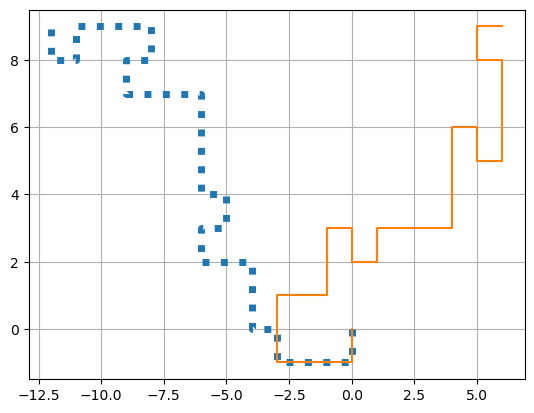

In [43]:
test = initial_SAW(30)
plt.plot(test[0,:],test[1,:],linestyle="dotted",linewidth=5)
new = pivot_step(test)
plt.plot(new[0,:],new[1,:])
plt.grid()
plt.xticks()
plt.show()

# Preliminary Tests

In [27]:
iterations = 10**7
N=15
coord = initial_SAW(N)
ω_squared, S_squared = pivot_run(coord,iterations)
mean_ω_squared = np.mean((ω_squared))
mean_S_squared = np.mean((S_squared))
std_ω_squared = np.std((ω_squared))
std_S_squared = np.std((S_squared))
print(f"Mean squared end-to-end distance is: {mean_ω_squared} ± {std_ω_squared}")
print(f"Mean squared gyration radius is: {mean_S_squared} ± {std_S_squared}")


100%|██████████| 10000000/10000000 [06:47<00:00, 24563.62it/s]


Mean squared end-to-end distance is: 42.7914466 ± 26.213990674434694
Mean squared gyration radius is: 6.1587173635555486 ± 2.0430559737802856


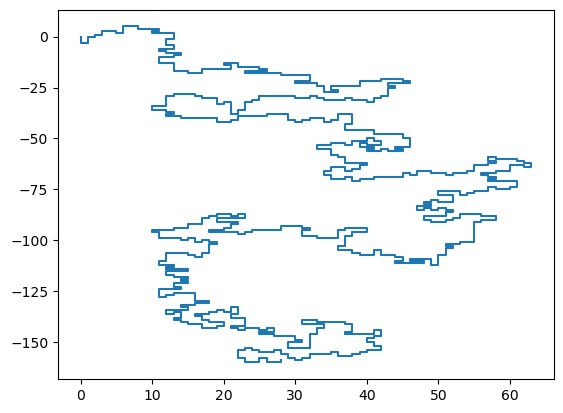

In [112]:
plt.plot(test[0,:],test[1,:])
plt.show()

In [6]:
import numpy as np
import time

# Create large random arrays
n, m = 20000, 20000
first = np.random.rand(n)
second = np.random.rand(n, m)

# Method 1: Broadcasting
start = time.time()
result1 = second + first[:, np.newaxis]
end = time.time()
print("Broadcasting time:", end - start)

# Method 2: Transposing
start = time.time()
result2 = (first + second.T).T  # Assuming first is (n, m), otherwise just first
end = time.time()
print("Transposing time:", end - start)

# Verify both methods produce the same result
print("Results match:", np.allclose(result1, result2))


Broadcasting time: 0.23731660842895508
Transposing time: 0.2448711395263672
Results match: True
